# Using CTGAN to synthesise data

Source: https://github.com/sdv-dev/CTGAN

- Uses Python to generate synthetic data
- Uses R for evaluation 

In [12]:
from ctgan import CTGANSynthesizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load dataset

In [13]:
df = pd.read_csv("./original_data/satgpa.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sex      1000 non-null   int64  
 1   sat_v    1000 non-null   int64  
 2   sat_m    1000 non-null   int64  
 3   sat_sum  1000 non-null   int64  
 4   hs_gpa   1000 non-null   float64
 5   fy_gpa   1000 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 47.0 KB


In [14]:
df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,65,62,127,3.40,3.18
1,2,58,64,122,4.00,3.33
2,2,56,60,116,3.75,3.25
3,1,42,53,95,3.75,2.42
4,1,55,52,107,4.00,2.63


In [15]:
# Set discrete columns
discrete_cols = [
    'sex'
]

## Generate synthetic data

Since the variable `sat_sum` is the sum of `sat_v` and `sat_m`, we need to drop the column before generating synthetic data.

In [17]:
df_copy = df.copy(deep=True)

df_copy = df_copy.drop(columns=['sat_sum'])

df_copy.head()

,sex,sat_v,sat_m,hs_gpa,fy_gpa
0,1,65,62,3.40,3.18
1,2,58,64,4.00,3.33
2,2,56,60,3.75,3.25
3,1,42,53,3.75,2.42
4,1,55,52,4.00,2.63


In [18]:
# Initialise and fit GAN
model = CTGANSynthesizer(batch_size=250, discriminator_steps=3, generator_lr=2e-3, discriminator_lr=2e-3)
model.fit(df_copy, discrete_cols)

C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 

Can ignore warnings as per developer's comments: https://github.com/sdv-dev/SDGym/issues/44

In [19]:
synth_df = model.sample(1000)

In [20]:
synth_df.head()

,sex,sat_v,sat_m,hs_gpa,fy_gpa
0,1,46,46,2.687051,1.831997
1,2,42,57,2.984383,1.633556
2,1,44,48,2.656724,2.752115
3,1,52,59,2.627774,3.301292
4,1,50,45,2.595438,1.590625


In [24]:
# Add sat_sum back on
sat_sum = synth_df['sat_v'] + synth_df['sat_m']
synth_df.insert(loc=3, column='sat_sum', value=sat_sum)

# Round to 2-decimal places
synth_df = synth_df.round(2)

synth_df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,46,46,92,2.69,1.83
1,2,42,57,99,2.98,1.63
2,1,44,48,92,2.66,2.75
3,1,52,59,111,2.63,3.30
4,1,50,45,95,2.60,1.59


In [25]:
# Paths
synth_model = "./synth_data/ctgan_model.pkl"
synth_output = "./synth_data/ctgan_method.csv"

# Output
model.save(synth_model)
synth_df.to_csv(synth_output, sep=",")

## Evaluation

We used an R package called Synthpop to perform evaluations. This lets us compare with CART methods.

In [6]:
# Read in synth data
synth_df = pd.read_csv(synth_output)

In [26]:
# Enables R in the notebook, only need to run once
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Visualise
First, we visualise the univariate distributions for each variable.

R[write to console]: Find out more at https://www.synthpop.org.uk/




Comparing percentages observed with synthetic

Press return for next variable(s): 


Selected utility measures:
           S_pMSE df
sex      1.444244  1
sat_v    9.512296  4
sat_m    5.617619  4
sat_sum 10.111462  4
hs_gpa  10.411141  4
fy_gpa  15.345299  4


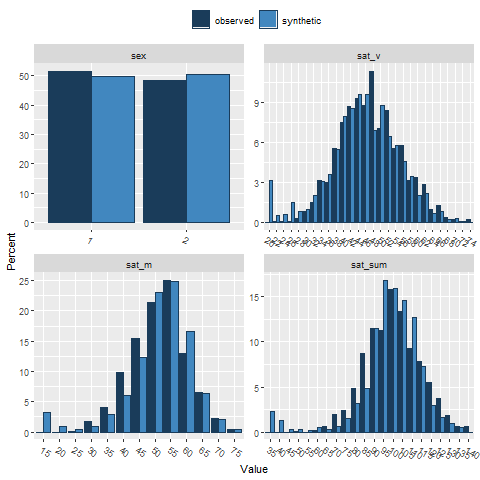

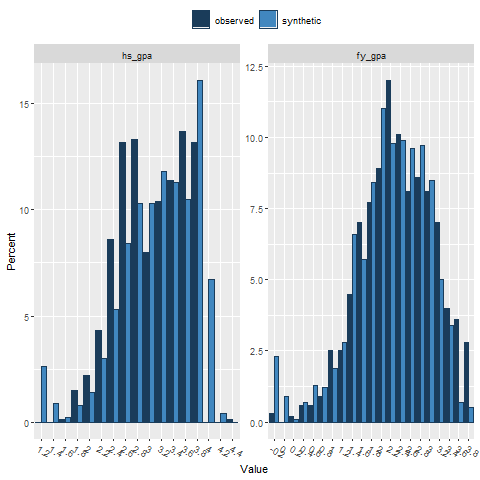

In [28]:
%%R -i df,synth_df

library(synthpop)

synthpop::compare(synth_df, df, utility.stats = c("S_pMSE", "df"))

### Utility scores

Visualises utility for all two-way tables.

A higher utility score is worse.


Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
5.hs_gpa:6.fy_gpa   2.sat_v:3.sat_m  2.sat_v:6.fy_gpa  2.sat_v:5.hs_gpa 
          13.0363            9.7939            8.4389            8.4284 
   1.sex:6.fy_gpa 
           8.0129 

Table of selected utility measures
                         VW       FT    JSD SPECKS WMabsDD        U        G
1.sex:2.sat_v       45.1411  45.4878 0.0082  0.076 19.2540 556479.5  46.6655
1.sex:3.sat_m       43.8940  44.2711 0.0080  0.083 21.7217 555625.0  45.9815
1.sex:4.sat_sum     53.0591  53.4312 0.0096  0.096 24.0701 565717.5  53.4057
1.sex:5.hs_gpa      51.7516  52.0501 0.0094  0.101 24.7867 564452.0  52.3766
1.sex:6.fy_gpa      72.1161  72.8312 0.0131  0.109 27.3085 574574.5  71.9464
2.sat_v:3.sat_m    235.0525 247.5933 0.0438  0.190 77.3385 634603.5 267.2205
2.sat_v:4.sat_sum  180.5507 202.6222 0.0345  0.157 69.3222 611221.5 199.5155
2.sat_v:5.hs_gpa   202.2808 211.3508 

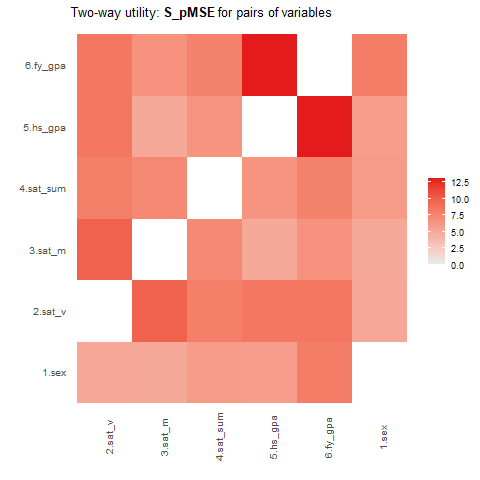

In [29]:
%%R -i df,synth_df

utility.tables(synth_df, df, tab.stats = "all", tables = "twoway", print.tabs = TRUE)